# Report

## Data Preprocessing

We will start by loading the data for the Apple stock and inspecting their first few rows.

In [1]:
import yfinance as yf
import pandas as pd

# Download Apple stock data
stock_prices = yf.download('AAPL', 
                   start='2015-01-01', 
                   end='2024-01-31')

# Display the first few rows
print("First few rows of Apple stock data:")
stock_prices.head()

[*********************100%***********************]  1 of 1 completed

First few rows of Apple stock data:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02 00:00:00+00:00,24.373959,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05 00:00:00+00:00,23.687307,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06 00:00:00+00:00,23.689535,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07 00:00:00+00:00,24.021717,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08 00:00:00+00:00,24.944691,27.972500,28.037500,27.174999,27.307501,237458000


Let's examine the path of the stock's closing price over time.

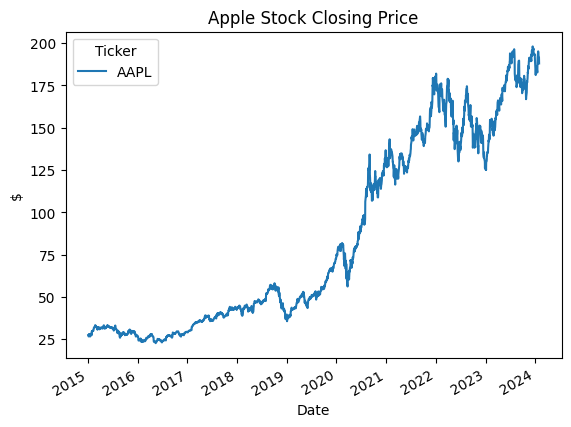

In [2]:
import matplotlib.pyplot as plt

stock_prices['Close'].plot()
plt.title('Apple Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()



The stock price has a clear upward (multiplicative) trend over time as expected from such a tech company. There is a dip in early 2019 and 2020 probably due to the COVID-19 pandemic, which is followed by a signigicant growh rate. The volatility seems to be inceasing as the price is increasing.

Let's check for any missing values in the dataset.


In [3]:
# Check for missing values in the dataset
stock_prices.isnull().sum()

Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64

There are no missing values in the dataset.

Since we are intrested in predicting extreme events, we will include three additional features that could provide useful information for the task at hand. Specifically, we will include:

-  10-day Rolling Volatility: Periods of high volatility often cluster together, and extreme events are more likely during volatile periods. 
-  Volume Relative to 10-day Moving Average: Unusual trading volume often precedes or accompanies extreme price movements.
- VIX Index: Market-wide volatility often correlates with individual stock extreme movements.

The 10-day window was chosen, since we will be predicting if an extreme event occurs tomorrow based on the past 10 days of data.

In [4]:
from src.data_preprocessing import add_features

stock_prices = add_features(stock_prices, start_date='2015-01-01', end_date='2024-01-31')
stock_prices.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,rolling_volatility,relative_volume,VIX
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,,
2015-01-16 00:00:00+00:00,23.629337,26.497499,26.895000,26.299999,26.757500,314053200,0.020765,1.336444,20.950001
2015-01-20 00:00:00+00:00,24.237963,27.180000,27.242500,26.625000,26.959999,199599600,0.020475,0.870711,19.889999
2015-01-21 00:00:00+00:00,24.423010,27.387501,27.764999,27.067499,27.237499,194303600,0.020516,0.873868,18.850000
2015-01-22 00:00:00+00:00,25.058386,28.100000,28.117500,27.430000,27.565001,215185600,0.021541,0.944521,16.400000
2015-01-23 00:00:00+00:00,25.187689,28.245001,28.437500,27.882500,28.075001,185859200,0.017986,0.834702,16.660000


We proceed with the calculation of the daily returns. We expect to have only one missing value in the daily returns due to the nature of the calculation.

We then define the extreme events, which will act as our target variable.

In [5]:
# Calculate the daily returns
stock_prices['Daily_Returns'] = stock_prices['Adj Close'].pct_change() * 100

# Remove the first row as it is a NaN value
stock_prices = stock_prices.dropna()
stock_prices.head()


Price,Adj Close,Close,High,Low,Open,Volume,rolling_volatility,relative_volume,VIX,Daily_Returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,,
2015-01-20 00:00:00+00:00,24.237963,27.180000,27.242500,26.625000,26.959999,199599600,0.020475,0.870711,19.889999,2.575719
2015-01-21 00:00:00+00:00,24.423010,27.387501,27.764999,27.067499,27.237499,194303600,0.020516,0.873868,18.850000,0.763460
2015-01-22 00:00:00+00:00,25.058386,28.100000,28.117500,27.430000,27.565001,215185600,0.021541,0.944521,16.400000,2.601547
2015-01-23 00:00:00+00:00,25.187689,28.245001,28.437500,27.882500,28.075001,185859200,0.017986,0.834702,16.660000,0.516007
2015-01-26 00:00:00+00:00,25.214443,28.275000,28.590000,28.200001,28.434999,222460000,0.017986,0.995652,15.520000,0.106220


In [6]:
# Create the Extreme_Event column
stock_prices['Extreme_Event'] = (abs(stock_prices['Daily_Returns']) > 2).astype(int)
stock_prices.head()


Price,Adj Close,Close,High,Low,Open,Volume,rolling_volatility,relative_volume,VIX,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,,
2015-01-20 00:00:00+00:00,24.237963,27.180000,27.242500,26.625000,26.959999,199599600,0.020475,0.870711,19.889999,2.575719,1
2015-01-21 00:00:00+00:00,24.423010,27.387501,27.764999,27.067499,27.237499,194303600,0.020516,0.873868,18.850000,0.763460,0
2015-01-22 00:00:00+00:00,25.058386,28.100000,28.117500,27.430000,27.565001,215185600,0.021541,0.944521,16.400000,2.601547,1
2015-01-23 00:00:00+00:00,25.187689,28.245001,28.437500,27.882500,28.075001,185859200,0.017986,0.834702,16.660000,0.516007,0
2015-01-26 00:00:00+00:00,25.214443,28.275000,28.590000,28.200001,28.434999,222460000,0.017986,0.995652,15.520000,0.106220,0


We expect that the dataset will be imbalanced. Let's verify that.

In [7]:
# Count the number of extreme events
extreme_events = stock_prices[stock_prices['Extreme_Event'] == 1]
print(f"Number of extreme events: {len(extreme_events)}")

# Print the percentage of extreme events and no extreme events in the dataset
print(f"Percentage of extreme events: {len(extreme_events) / len(stock_prices) * 100:.2f}%")
print(f"Percentage of no extreme events: {(len(stock_prices) - len(extreme_events)) / len(stock_prices) * 100:.2f}%")



Number of extreme events: 456
Percentage of extreme events: 20.06%
Percentage of no extreme events: 79.94%


**The dataset is moderately imbalanced with approximately 20% of the data being extreme events. This is a challenge that we will have to address in the modelling phase.**

Our choices for doing so are limited, since we are dealing with a time-series dataset and we need to preserve the temporal nature of the data, which excludes the use of resampling techniques.

For the random forest model, we will scale the loss function using the class weights.

Next, we shift the target variable `Extreme_Event` by one day so that the model is trained to predict if an extreme event occurs **tomorrow** based on today's data.

In [8]:
# Shift the Extreme_Event column by one day
stock_prices['Extreme_Event'] = stock_prices['Extreme_Event'].shift(-1)

# Remove the last row as it is a NaN value
stock_prices = stock_prices.dropna()
stock_prices['Extreme_Event'] = stock_prices['Extreme_Event'].astype(int)
stock_prices.head()

Price,Adj Close,Close,High,Low,Open,Volume,rolling_volatility,relative_volume,VIX,Daily_Returns,Extreme_Event
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,,
2015-01-20 00:00:00+00:00,24.237963,27.180000,27.242500,26.625000,26.959999,199599600,0.020475,0.870711,19.889999,2.575719,0
2015-01-21 00:00:00+00:00,24.423010,27.387501,27.764999,27.067499,27.237499,194303600,0.020516,0.873868,18.850000,0.763460,1
2015-01-22 00:00:00+00:00,25.058386,28.100000,28.117500,27.430000,27.565001,215185600,0.021541,0.944521,16.400000,2.601547,0
2015-01-23 00:00:00+00:00,25.187689,28.245001,28.437500,27.882500,28.075001,185859200,0.017986,0.834702,16.660000,0.516007,0
2015-01-26 00:00:00+00:00,25.214443,28.275000,28.590000,28.200001,28.434999,222460000,0.017986,0.995652,15.520000,0.106220,1


We continue by splitting the data into training, validation and test sets.


In [10]:
# Extract features and labels
features = stock_prices[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Returns', 'rolling_volatility', 'relative_volume', 'VIX']]
labels = stock_prices['Extreme_Event'].astype(int)  # Target variable

# Define train/val/test split ratios
train_ratio = 0.7
val_ratio = 0.85

# Split into train, validation and test sets
train_size = int(train_ratio * len(stock_prices))
val_size = int(val_ratio * len(stock_prices))

X_train = features.iloc[:train_size]
y_train = labels.iloc[:train_size]

X_val = features.iloc[train_size:val_size]
y_val = labels.iloc[train_size:val_size]

X_test = features.iloc[val_size:]
y_test = labels.iloc[val_size:]

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")

Training features shape: (1590, 9), labels shape: (1590,)
Validation features shape: (341, 9), labels shape: (341,)
Test features shape: (341, 9), labels shape: (341,)


Let's check the distribution of labels in the training, validation and test sets. We want to avoid underestimating the performance of the model on unseen data, due to total lack of positive examples.

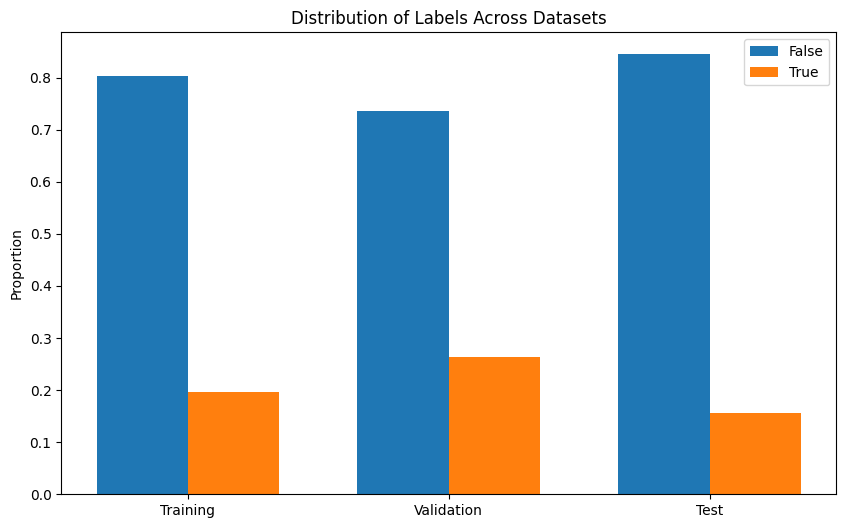

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate distributions
train_dist = y_train.value_counts() / len(y_train)
val_dist = y_val.value_counts() / len(y_val)
test_dist = y_test.value_counts() / len(y_test)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(3)
width = 0.35

# Group bars by False/True
false_vals = [train_dist[0], val_dist[0], test_dist[0]]
true_vals = [train_dist[1], val_dist[1], test_dist[1]]

ax.bar(x - width/2, false_vals, width, label='False')
ax.bar(x + width/2, true_vals, width, label='True')

ax.set_xticks(x)
ax.set_xticklabels(['Training', 'Validation', 'Test'])
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Labels Across Datasets')
ax.legend()

plt.show()


The distribution of labels is similar across the datasets, so we can procced with fitting the models.

As a final step of preprocessing, we will transform the data into a more appropriate format for supervised learning. Specifically, for each day, we will create a sequence of historical features by going back 10 days. Hence, since we the dataset has 9 features, we will end up with 90 features for each day. The corresponding label will be 1 if an extreme event occurs tomorrow and 0 otherwise.

In [12]:
from src.data_preprocessing import time_series_to_supervised

X_train, y_train = time_series_to_supervised(X_train, y_train, lookback=10)
X_val, y_val = time_series_to_supervised(X_val, y_val, lookback=10)
X_test, y_test = time_series_to_supervised(X_test, y_test, lookback=10)

print(f"Training features shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test features shape: {X_test.shape}, labels shape: {y_test.shape}")


Training features shape: (1580, 90), labels shape: (1580,)
Validation features shape: (331, 90), labels shape: (331,)
Test features shape: (331, 90), labels shape: (331,)


# Random Forest Model

Now we will proceed with fitting the random forest model. Since we are using a tree-based model, we will not normalize the data.

In order to tune the hyperparameters of the random forest model, we will use the `hyperopt` library. It uses a Bayesian optimization approach to find the best hyperparameters, called `Tree of Parzen Estimators` (TPE). 

In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def objective(params):
    """
    Objective function for hyperopt optimization.
    """
    # Convert continuous params to integers where needed
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth']) 
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    
    # Add fixed parameters
    params.update({
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    })
    
    # Create and train model
    model = RandomForestClassifier(**params)
    model.fit(X_train.values, y_train.values.astype(int))
    
    # Evaluate on validation set
    y_pred = model.predict(X_val.values)
    f1 = f1_score(y_val.values.astype(int), y_pred)
    
    return {'loss': -f1, 'status': STATUS_OK}

# Choices for categorical parameters
criterion_choices = ['entropy', 'log_loss']
class_weight_choices = ['balanced', 'balanced_subsample']

# Search space
space = {
    'n_estimators': hp.quniform('n_estimators', 900, 1500, 1),
    'max_depth': hp.quniform('max_depth', 70, 100, 1),
    'min_samples_split': hp.quniform('min_samples_split', 10, 25, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 4, 10, 1),
    'max_features': hp.uniform('max_features', 0.8, 1.0),
    'criterion': hp.choice('criterion', criterion_choices),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 500, 700, 1),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.04, 0.08),
    'class_weight': hp.choice('class_weight', class_weight_choices)
}

# Run optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Print results
print("\nBest parameters:")
for key, value in best.items():
    print(f"    {key}: {value}")

# Get best f1 score from trials
best_f1 = -min(trials.losses())
print(f"\nBest validation F1 score: {best_f1:.4f}")



100%|██████████| 50/50 [02:14<00:00,  2.70s/trial, best loss: -0.47337278106508873]

Best parameters:
    class_weight: 1
    criterion: 0
    max_depth: 93.0
    max_features: 0.804696392299343
    max_leaf_nodes: 595.0
    min_impurity_decrease: 0.048974103962778306
    min_samples_leaf: 8.0
    min_samples_split: 14.0
    n_estimators: 1000.0

Best validation F1 score: 0.4734


We see that most of the optimal hyperparameters fall within the ranges of the search space, so probably there is not much room for improvement with the particular model and dataset.

We proceed with fitting the final model with the best parameters and evaluating on the test set.

In [17]:
# Train final model with best parameters
best_params = best.copy()
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split']) 
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['max_leaf_nodes'] = int(best_params['max_leaf_nodes'])
best_params['criterion'] = criterion_choices[int(best_params['criterion'])]
best_params['class_weight'] = class_weight_choices[int(best_params['class_weight'])]
best_params.update({
    'bootstrap': True,
    'class_weight': best_params['class_weight'],
    'random_state': 42,
    'n_jobs': -1
})

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train.values, y_train.values.astype(int))

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=93, max_features=np.float64(0.804696392299343),
                       max_leaf_nodes=595,
                       min_impurity_decrease=np.float64(0.048974103962778306),
                       min_samples_leaf=8, min_samples_split=14,
                       n_estimators=1000, n_jobs=-1, random_state=42)

Test Set Metrics:
----------------------------------------
F1 Score            : 0.3349
Precision           : 0.2174
Recall              : 0.7292
Accuracy            : 0.5801
AUC                 : 0.6420
Balanced Accuracy   : 0.6420
----------------------------------------


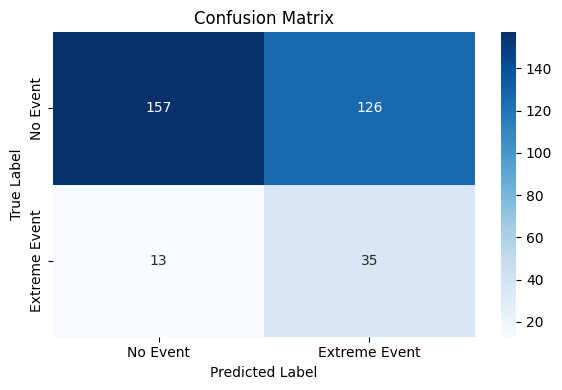

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, roc_auc_score, balanced_accuracy_score, 
                           precision_score, recall_score, confusion_matrix, f1_score)

# Make predictions
y_pred = final_model.predict(X_test.values)
y_true = y_test.values.astype(int)

# Calculate metrics
metrics = {
    'F1 Score': f1_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'Accuracy': accuracy_score(y_true, y_pred),
    'AUC': roc_auc_score(y_true, y_pred),
    'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred)
}

# Print metrics in a organized way
print("Test Set Metrics:")
print("-" * 40)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")
print("-" * 40)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Event', 'Extreme Event'],
            yticklabels=['No Event', 'Extreme Event'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


As expected, 

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score
print(f"Test Set Accuracy: {accuracy_score(y_test.values.astype(int), y_pred):.4f}")
print(f"Test Set AUC: {roc_auc_score(y_test.values.astype(int), y_pred):.4f}")
print(f"Test Set Balanced Accuracy: {balanced_accuracy_score(y_test.values.astype(int), y_pred):.4f}")

Test Set Accuracy: 0.7477
Test Set AUC: 0.5339
Test Set Balanced Accuracy: 0.5339
